In [1198]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1199]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from src.model import Model

def dr(df):
    with pd.option_context('display.max_rows', None):
        display(df)
        
def dc(df):
    with pd.option_context('display.max_columns', None):
        display(df)
        
def drc(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
dcr = drc

In [1278]:
results = pd.read_csv("match_results/results_clean.csv", parse_dates=["date"])

def get_results(team, res=results, start_date=None, end_date = None):
    df_ = res.query(f"home_team == '{team}' or away_team == '{team}'")
    if start_date is not None:
        df_ = df_.loc[df_.date >= start_date]
    if end_date is not None:
        df_ = df_.loc[df_.date <= end_date]
    return df_

<Axes: ylabel='Frequency'>

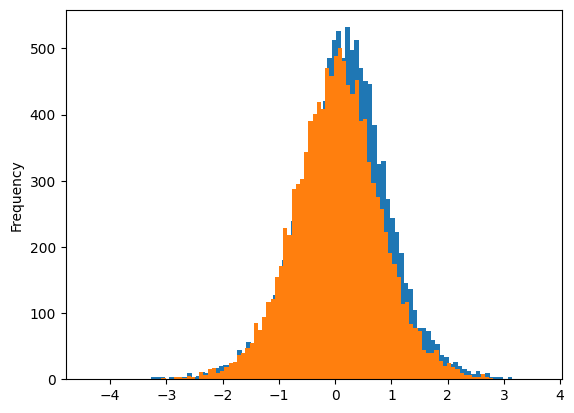

In [1335]:
np.log(res.exp_home_goals).plot.hist(bins=100)
np.log(res.exp_away_goals).plot.hist(bins=100)

In [ ]:
import cProfile, pstats, io

pr = cProfile.Profile()
pr.enable()

model = Model(
    maintain_param_history=True, 
    recenter_params=True, 
    variance_per_year=0.2, 
    rho=0.1,
    hga=0.2,
    hga_ratio=1.0, 
    hga_prior_var=5e-3, 
    hga_rw_var_per_year=1e-3
)
res = model.fit()

pr.disable()

s = io.StringIO()
ps = pstats.Stats(pr, stream=s).strip_dirs().sort_stats("cumtime")
ps.print_stats(20)
print(s.getvalue())

         16130684 function calls (16130414 primitive calls) in 9.856 seconds

   Ordered by: cumulative time
   List reduced from 675 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    9.863    3.288 interactiveshell.py:3543(run_code)
        3    0.000    0.000    9.863    3.288 {built-in method builtins.exec}
        1    0.224    0.224    9.832    9.832 model.py:132(fit)
    11655    0.126    0.000    5.313    0.000 model.py:531(_compute_updated_ratings)
    11655    0.480    0.000    4.428    0.000 optimiser.py:197(fisher_scoring_armijo_fast)
    11655    1.807    0.000    2.988    0.000 model.py:355(_recenter_params)
   120307    0.844    0.000    1.729    0.000 model.py:603(_loglik_and_ubar)
    53759    0.184    0.000    1.267    0.000 model.py:668(grad)
    54893    0.165    0.000    1.193    0.000 model.py:655(f)
    11655    0.425    0.000    1.039    0.000 model.py:842(_result_probabilities)
 

<Axes: xlabel='year'>

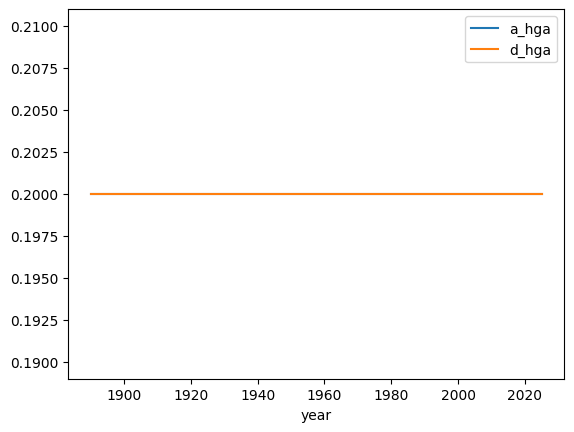

In [1311]:
model.export_hga_df().set_index("year")[["a_hga", "d_hga"]].plot()

In [924]:
history = model.export_state_df()
history["quality"] = history["mu_attack"] + history["mu_defense"]
history["quality_lo"] = history["quality"] - 2 * np.sqrt(history["sigma_attack"] + history["sigma_defense"] * 2 * history["sigma_ad"])
history["rank"] = (
    history.groupby("date")["quality"]
    .rank(ascending=False, method="dense")
).astype(int)
history["rank_lo"] = (
    history.groupby("date")["quality_lo"]
    .rank(ascending=False, method="dense")
).astype(int)
history_us = history.set_index(["date", "team"]).unstack()

history.sample(5)

,date,team,mu_attack,mu_defense,sigma_attack,sigma_defense,sigma_ad,mu_global,quality,quality_lo,rank,rank_lo
336747,2000-08-13,Brunei,-0.295903,-1.934554,1.086898,0.542615,0.0,-0.005404,-2.230456,-4.315545,179,172
341462,2001-01-20,Brunei,-0.288474,-1.944248,1.086898,0.542615,0.0,-0.022527,-2.232722,-4.317810,180,174
388968,2004-06-16,Mauritius,0.340591,0.372358,0.538293,0.665664,0.0,-0.018213,0.712950,-0.754419,79,81
342842,2001-02-14,St Vincent and the Grenadines,-0.535078,-0.245496,1.092993,0.684215,0.0,-0.034616,-0.780574,-2.871500,146,151
594228,2021-11-11,Mongolia,-0.733431,-0.806289,1.232525,1.581960,0.0,0.016386,-1.539720,-3.760103,172,182


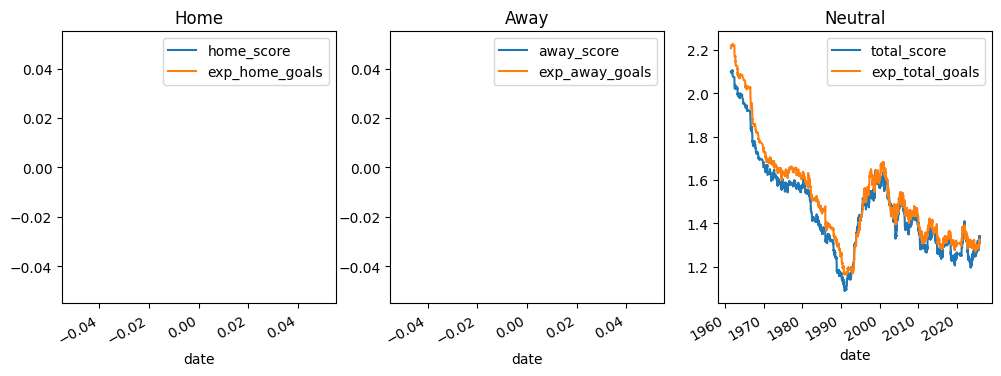

In [1322]:
N = 500
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
R = res.query("home_games_played >= 10 and home_games_played >= 10").copy()
R["total_score"] = R["home_score"] + R["away_score"]
R["exp_total_goals"] = R["exp_home_goals"] + R["exp_away_goals"]
R.query("~neutral").set_index("date")[["home_score", "exp_home_goals"]].rolling(N).mean().plot(ax=axs[0], title="Home")
R.query("~neutral").set_index("date")[["away_score", "exp_away_goals"]].rolling(N).mean().plot(ax=axs[1], title="Away")
(R.query("neutral").set_index("date")[["total_score", "exp_total_goals"]]/2).rolling(N).mean().plot(ax=axs[2], title="Neutral")
plt.show()

0.29 0.29


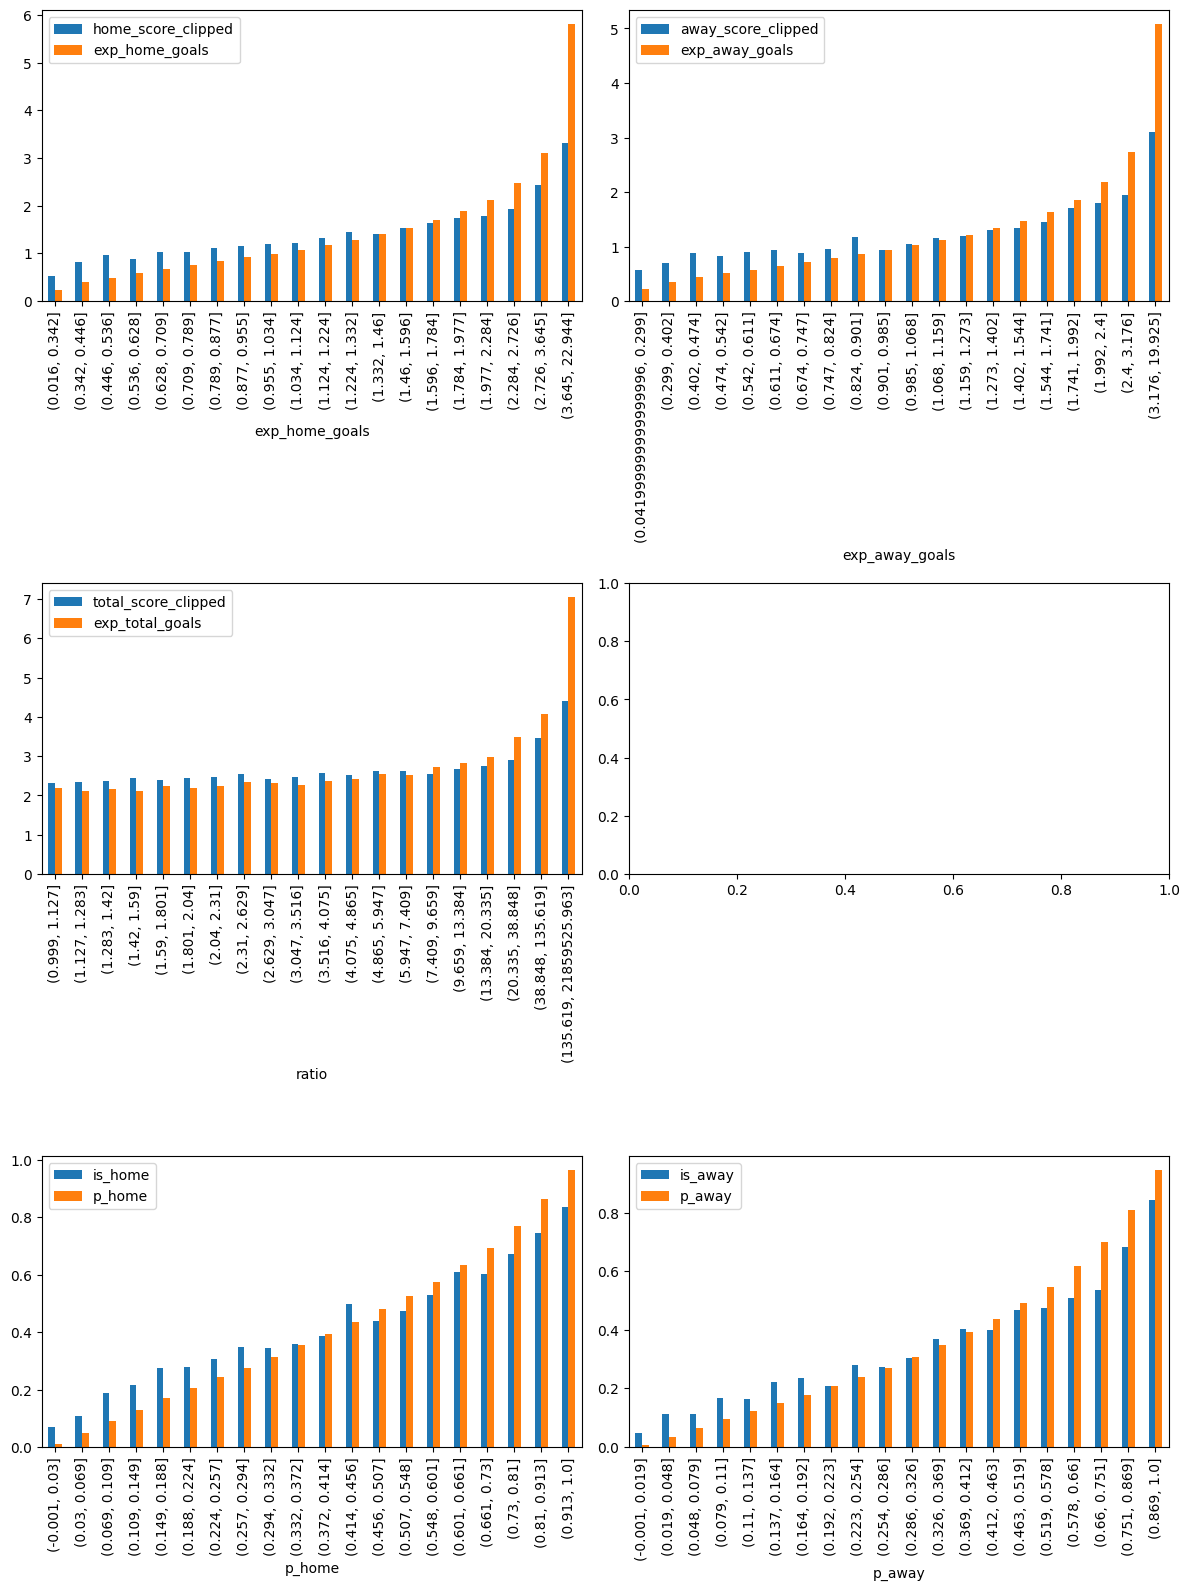

In [1325]:
"""
No scaling      1.16 / 0.80
Power 1/1       0.23 / 0.28
"""

R = res.query("date > '2000' and home_games_played >= 10 and home_games_played >= 10").reset_index().copy()
R["is_home"] = R.home_score > R.away_score
R["is_draw"] = R.home_score == R.away_score
R["is_away"] = R.home_score < R.away_score
R["total_score"] = R[["home_score", "away_score"]].sum(axis=1)
R["exp_total_goals"] = R[["exp_home_goals", "exp_away_goals"]].sum(axis=1)
R["ratio"] = R[["p_home", "p_away"]].max(axis=1) / R[["p_home", "p_away"]].min(axis=1)

fig, axs = plt.subplots(3, 2, figsize=(12,16))
axs = axs.flatten()

q = 20
R["home_score_clipped"] = R.home_score.clip(0, 8)
R["away_score_clipped"] = R.away_score.clip(0, 8)
R["total_score_clipped"] = R["home_score_clipped"] + R["away_score_clipped"]
(R.groupby(pd.qcut((R.exp_away_goals).round(3), q=q), observed=False)[["away_score_clipped", "exp_away_goals"]].mean()).plot.bar(ax=axs[1])
(R.groupby(pd.qcut((R.exp_home_goals).round(3), q=q), observed=False)[["home_score_clipped", "exp_home_goals"]].mean()).plot.bar(ax=axs[0])
# bins = [-100, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 100]
# (R.groupby(pd.cut(np.log(R.exp_away_goals).round(3), bins=bins), observed=False)[["away_score", "exp_away_goals"]].mean()).plot.bar(ax=axs[1])
# (R.groupby(pd.cut(np.log(R.exp_home_goals).round(3), bins=bins), observed=False)[["home_score", "exp_home_goals"]].mean()).plot.bar(ax=axs[0])
print(
    round(np.log(R.groupby(pd.qcut(R.exp_home_goals.round(3), q=q), observed=False)[["home_score_clipped", "exp_home_goals"]].mean()).eval("L = abs(home_score_clipped - exp_home_goals) ** 1").L.mean(), 2),
    round(np.log(R.groupby(pd.qcut(R.exp_away_goals.round(3), q=q), observed=False)[["away_score_clipped", "exp_away_goals"]].mean()).eval("L = abs(away_score_clipped - exp_away_goals) ** 1").L.mean(), 2)
)

R.groupby(pd.qcut(R.ratio.round(3), q=q), observed=False)[["total_score_clipped", "exp_total_goals"]].mean().round(3).plot.bar(ax=axs[2])
R.groupby(pd.qcut(R.p_home.round(3), q=q), observed=False)[["is_home", "p_home"]].mean().round(3).plot.bar(ax=axs[4])
R.groupby(pd.qcut(R.p_away.round(3), q=q), observed=False)[["is_away", "p_away"]].mean().round(3).plot.bar(ax=axs[5])

plt.tight_layout()
plt.show()

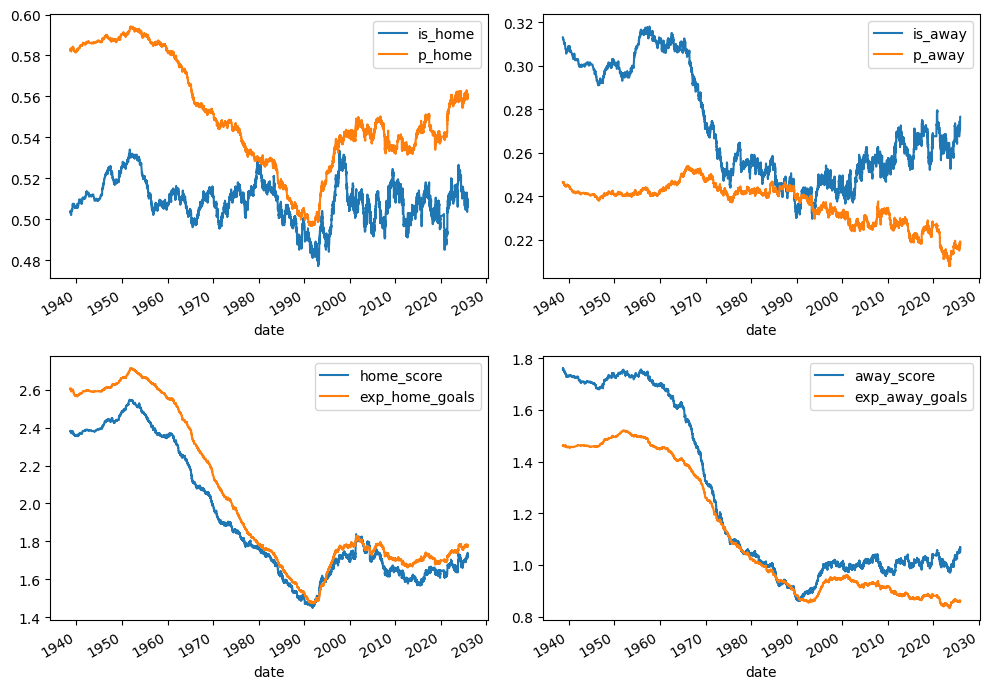

In [960]:
# Diagnostics for home ground advantage

r = 2000

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

R = res.query("~neutral").reset_index().copy()
R["is_home"] = R.home_score > R.away_score
R["is_draw"] = R.home_score == R.away_score
R["is_away"] = R.home_score < R.away_score

R.set_index("date")[["is_home", "p_home"]].rolling(r).mean().plot(ax=axs[0][0])
R.set_index("date")[["is_away", "p_away"]].rolling(r).mean().plot(ax=axs[0][1])

R.set_index("date")[["home_score", "exp_home_goals"]].rolling(r).mean().plot(ax=axs[1][0])
R.set_index("date")[["away_score", "exp_away_goals"]].rolling(r).mean().plot(ax=axs[1][1])

plt.tight_layout()
plt.show()

<Axes: xlabel='date'>

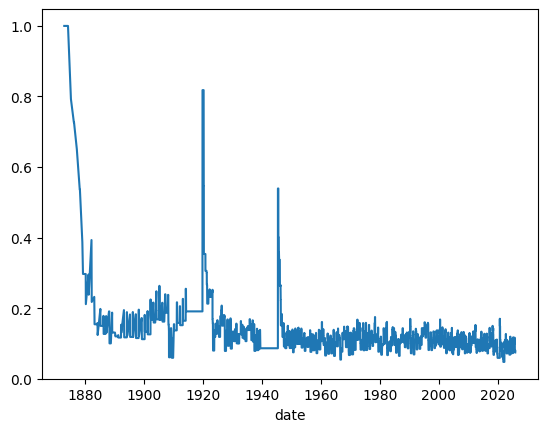

In [503]:
history.query("team == 'England'").set_index("date").sigma_attack.clip(0, 1).plot()

In [504]:
history.query("rank_lo <= 1").team.value_counts()

team
Brazil            4233
England           1442
Argentina         1393
Germany           1349
Italy             1308
France            1200
Netherlands        982
Spain              955
Scotland           674
Russia             527
Denmark            253
Mexico             237
Uruguay            178
Costa Rica         170
Colombia           137
Czechia            120
Czechoslovakia     115
Austria            114
Sweden              86
Hungary             59
Ireland             43
Portugal            35
Belgium             32
Switzerland         32
Norway              31
Croatia             30
Yugoslavia          11
Romania              9
East Germany         7
Chile                5
Wales                4
Egypt                2
Name: count, dtype: int64

<Axes: xlabel='date'>

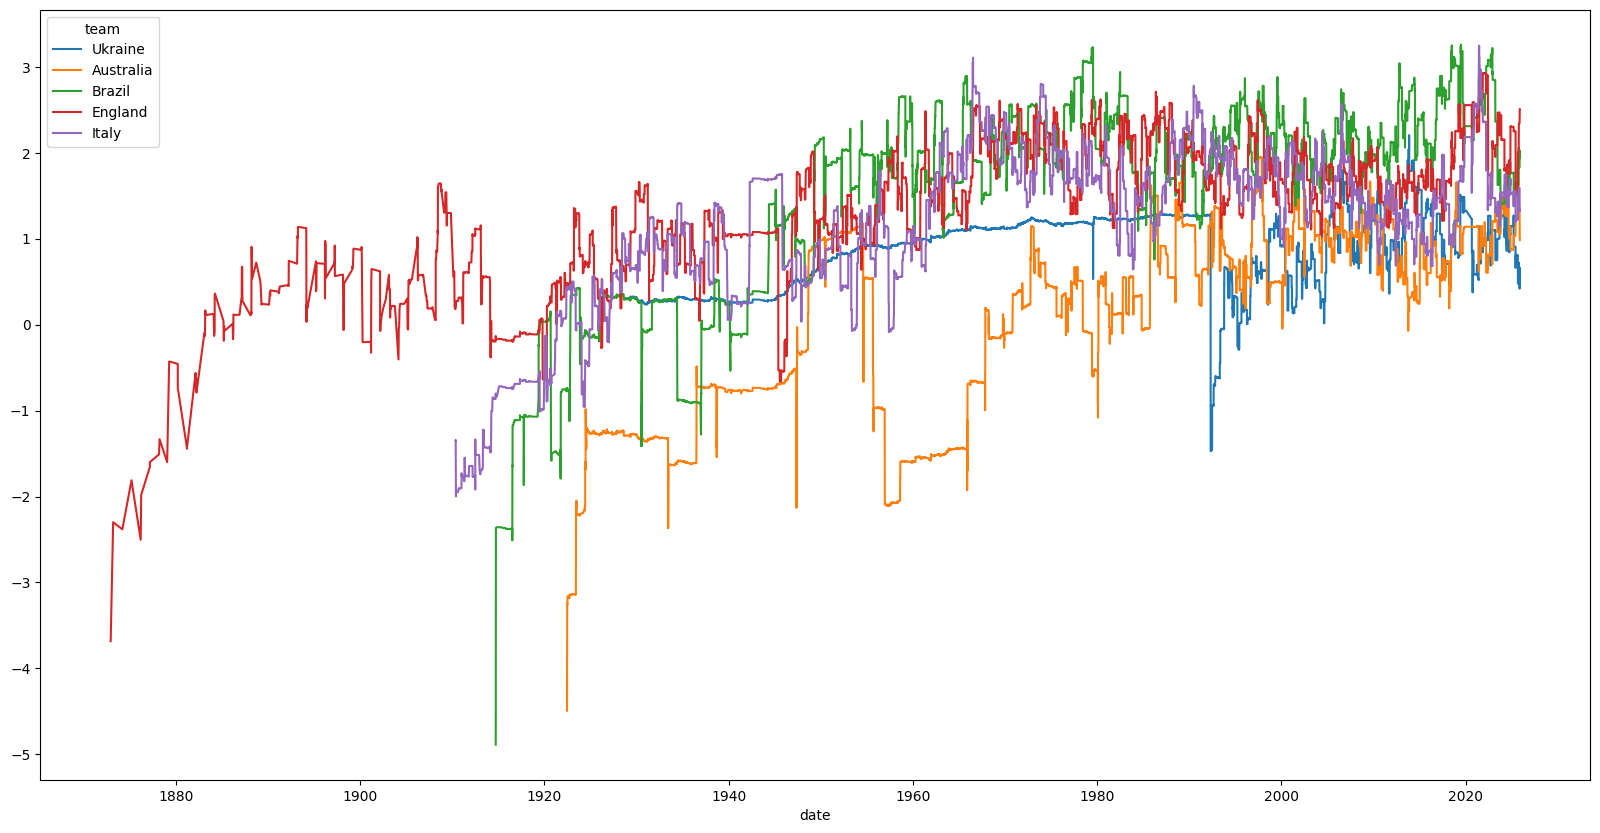

In [513]:
history_us.quality_lo[["Ukraine", "Australia", "Brazil", "England", "Italy"]].plot(figsize=(20, 10))

In [414]:
get_results("Guam", end_date="2014-03-27")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,shootout_winner,shootout_first_shooter
9768,1975-08-02,Guam,Solomon Islands,1,5,South Pacific Games,Tamuning,Guam,False,NaN,NaN
9777,1975-08-04,Guam,Fiji,0,11,South Pacific Games,Tamuning,Guam,False,NaN,NaN
11389,1979-08-29,Guam,Vanuatu,0,4,South Pacific Games,Suva,Fiji,True,NaN,NaN
11394,1979-08-30,Guam,New Caledonia,1,10,South Pacific Games,Suva,Fiji,True,NaN,NaN
11406,1979-09-05,Guam,Samoa,4,2,South Pacific Games,Nausori,Fiji,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
34770,2012-12-07,Guam,Australia,0,9,EAFF Championship,So Kon Po,Hong Kong,True,NaN,NaN
34969,2013-03-02,Myanmar,Guam,5,0,AFC Challenge Cup qualification,Yangon,Myanmar,False,NaN,NaN
34974,2013-03-04,Guam,India,0,4,AFC Challenge Cup qualification,Yangon,Myanmar,True,NaN,NaN
35668,2013-11-19,Cambodia,Guam,0,2,Friendly,Phnom Penh,Cambodia,False,NaN,NaN


In [412]:
get_results("Aruba", end_date="2014-03-27")

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,shootout_winner,shootout_first_shooter
833,1924-04-06,Aruba,Curacao,0,4,Friendly,Oranjestad,Aruba,False,NaN,NaN
1379,1930-04-20,Curacao,Aruba,2,1,Friendly,Willemstad,Curaçao,False,NaN,NaN
1479,1931-04-05,Curacao,Aruba,1,0,Friendly,Willemstad,Curaçao,False,NaN,NaN
1712,1933-10-08,Aruba,Curacao,1,3,Friendly,Oranjestad,Aruba,False,NaN,NaN
1714,1933-10-11,Aruba,Curacao,0,2,Friendly,Oranjestad,Aruba,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
34520,2012-09-23,Aruba,Dominican Republic,2,2,CFU Caribbean Cup qualification,Bridgetown,Barbados,True,NaN,NaN
34523,2012-09-25,Dominica,Aruba,3,2,CFU Caribbean Cup qualification,Bridgetown,Barbados,True,NaN,NaN
34526,2012-09-27,Barbados,Aruba,2,1,CFU Caribbean Cup qualification,Bridgetown,Barbados,False,NaN,NaN
35617,2013-11-14,Curacao,Aruba,2,0,ABCS Tournament,Willemstad,Curaçao,False,NaN,NaN


In [353]:
date_first_match = np.minimum(results.groupby("home_team").date.min(), results.groupby("away_team").date.min())
current_rating = df.groupby("team").last()[["mu_attack", "mu_defense", "quality", "date"]].rename(columns={"date": "date_last_match"})
ratings = current_rating.join(date_first_match).rename(columns={"date": "date_first_match"})

<Axes: xlabel='date_first_match', ylabel='quality'>

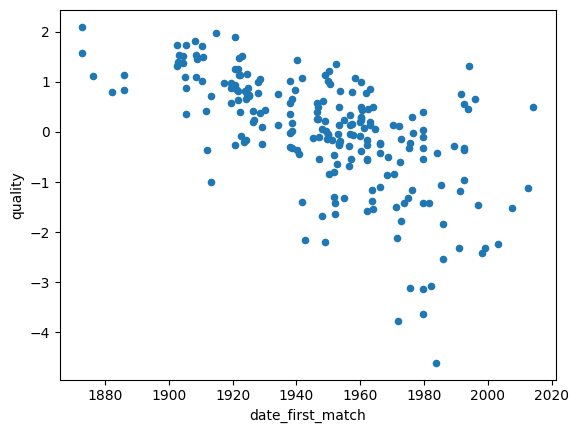

In [354]:
ratings.plot.scatter("date_first_match", "quality")

<Axes: xlabel='date_first_match', ylabel='quality'>

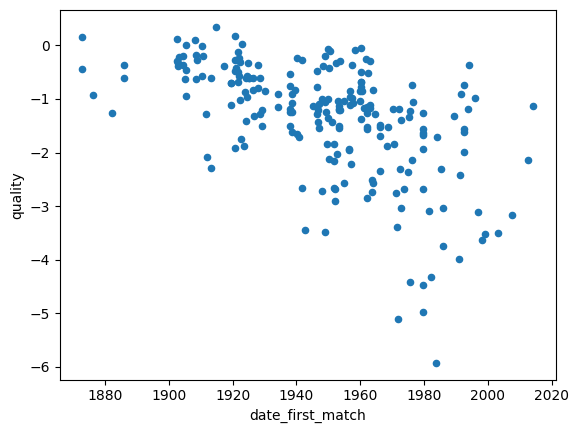

In [349]:
ratings.plot.scatter("date_first_match", "quality")